In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from l0bnb import fit_path

In [2]:
Hitters = load_data('Hitters')
print(np.isnan(Hitters['Salary']).sum())
Hitters = Hitters.dropna()
print(Hitters.shape)
print(Hitters.dtypes)

59
(263, 20)
AtBat           int64
Hits            int64
HmRun           int64
Runs            int64
RBI             int64
Walks           int64
Years           int64
CAtBat          int64
CHits           int64
CHmRun          int64
CRuns           int64
CRBI            int64
CWalks          int64
League       category
Division     category
PutOuts         int64
Assists         int64
Errors          int64
Salary        float64
NewLeague    category
dtype: object


sklearnd doesn't have Cp (as I correctly saw in the titanic dataset feature selection), so here's a function to compute it by oneself.

In [3]:
def nCp(sigma2:float,     # variance
        estimator,
        X:pd.DataFrame,   # all data without the response
        Y:pd.Series) -> float:
    'Negative Cp statistic'
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

Estimating sigma2 (the variance) using the biggest model (= has the highest variance)

In [4]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

We want to use sigma2 as a const in the function nCp, so we freeze the function with that. This is then our "scorer", although I don't quite know what that means.

In [5]:
neg_Cp = partial(nCp, sigma2)

Apart from the scorer, we need a Search strategy. From the book Lab: The method `Stepwise.first_peak()` runs forward stepwise until any further additions to the model do not result in an improvement in the evaluation score. Similarly, the method `Stepwise.fixed_steps()` runs a fixed number of steps of stepwise search.

In [6]:
strategy = Stepwise.first_peak(design,                      # our model (with the intercept)
                               direction='forward',         # forward, backward or both
                               max_terms=len(design.terms)) # number of predictors

Now to implement forward selection. This is done with the function sklearn_selected() from the ISLP package. It takes a model from statsmodels and a search strategy, and then you can compute by using its fit() method.

In [7]:
hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, # the response column is still in the dataset!
                Y)
print(hitters_MSE.selected_state_)
print(len(hitters_MSE.selected_state_))
print(dir(hitters_MSE))
print(hitters_MSE.__class__)
print(type(hitters_MSE)) # its the same as the line before

('Assists', 'AtBat', 'CAtBat', 'CHits', 'CHmRun', 'CRBI', 'CRuns', 'CWalks', 'Division', 'Errors', 'Hits', 'HmRun', 'League', 'NewLeague', 'PutOuts', 'RBI', 'Runs', 'Walks', 'Years')
19
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__str__', '__subclasshook__', '__weakref__', '_build_request_for_signature', '_check_feature_names', '_check_n_features', '_estimator_type', '_get_default_requests', '_get_metadata_request', '_get_param_names', '_get_tags', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', '_validate_params', 'cv', 'fit', 'get_metadata_routing', 'get_params', 'model_', 'model_args', 'model_type', 'predict', 'results_', 'score', 'scoring

Now to use neg_Cp as the scoring argument for sklearn_selected(), so it doesn't use the MSE (and thus doesn't use the MSE which always results in the largest model)

In [8]:
hitters_Cp = sklearn_selected(OLS,
                              strategy,
                              scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
print(hitters_Cp.selected_state_)
print(len(hitters_Cp.selected_state_))

('Assists', 'AtBat', 'CAtBat', 'CRBI', 'CRuns', 'CWalks', 'Division', 'Hits', 'PutOuts', 'Walks')
10


# Using CV and Validation Set Approach for choosing a model

Now we use fixed_steps instead of first_peak. I don't know exactly what the difference is, but I think when using MSE as a score for first_peak (its default), it's the same as the fixed_steps for the length of the variables, since it will always add another variable, because the MSE will always be lower.

In [9]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),      # steps to take (total iterations -1)
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)       # doesn't need a scorer since it makes all iterations anyway (?)

"full_path" is now our full forward selection.

In [10]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

Gives us an arry of shape (253, 20): 20 different values (for 20 different steps) for all 263 observations.

Preparation for comparing the MSE to other methods of scoring:

(50000.0, 250000.0)

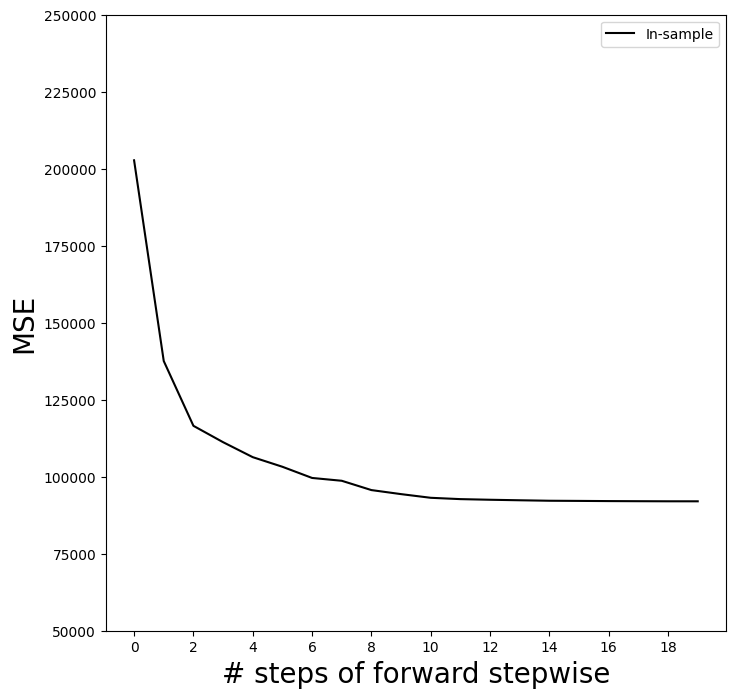

In [11]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000])

Computing 5fold CV predicted values:

In [12]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,  # forward selection
                                Hitters,    # data
                                Y,          # response
                                cv=kfold)   # "BaseCrossValidator"?
Yhat_cv.shape

(263, 20)

Getting the MSE for every fold for every iteration. The shuffle will be the same, since we set a random_state

In [13]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y): # 5 times
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2 # computing all MSE of one fold of EACH iteration
    cv_mse.append(errors.mean(0)) # getting the mean of those MSE
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

For better visualization, this is what kfold.split(Y) looks like: A training array with the IDs of all training data and a smaller test set with the IDs of the test data. All in all 5 times for the 5 different folds. The computation above simply takes those IDs of the test sets and computes the mean squared error using already known Y and Yhat.

In [14]:
for train_idx, test_idx in kfold.split(Y):
    print('Train IDX:', train_idx, '\nTest IDX:', test_idx)

Train IDX: [  0   1   2   3   4   6   9  10  11  13  14  15  16  17  18  19  21  23
  24  25  26  28  29  30  31  32  33  34  35  36  38  39  40  41  42  43
  44  46  47  48  49  50  51  52  53  54  56  57  58  60  61  62  64  65
  66  67  68  69  70  71  72  75  77  78  79  80  81  82  84  85  86  87
  88  89  90  91  93  94  95  96  97  98  99 100 102 103 104 105 107 108
 111 112 113 114 115 116 117 118 119 120 121 123 127 128 130 131 132 133
 135 137 138 139 140 141 142 143 144 145 147 148 149 151 152 156 157 159
 160 162 163 164 165 166 167 169 170 172 173 174 175 176 177 179 181 182
 183 185 186 187 188 189 190 191 192 193 195 197 198 199 201 202 203 206
 208 209 210 211 212 213 214 216 217 218 219 221 222 223 224 225 226 227
 228 229 230 232 233 234 235 236 237 238 241 242 244 245 246 247 248 249
 250 251 252 254 255 256 257 258 259 260 261 262] 
Test IDX: [  5   7   8  12  20  22  27  37  45  55  59  63  73  74  76  83  92 101
 106 109 110 122 124 125 126 129 134 136 146 150 153

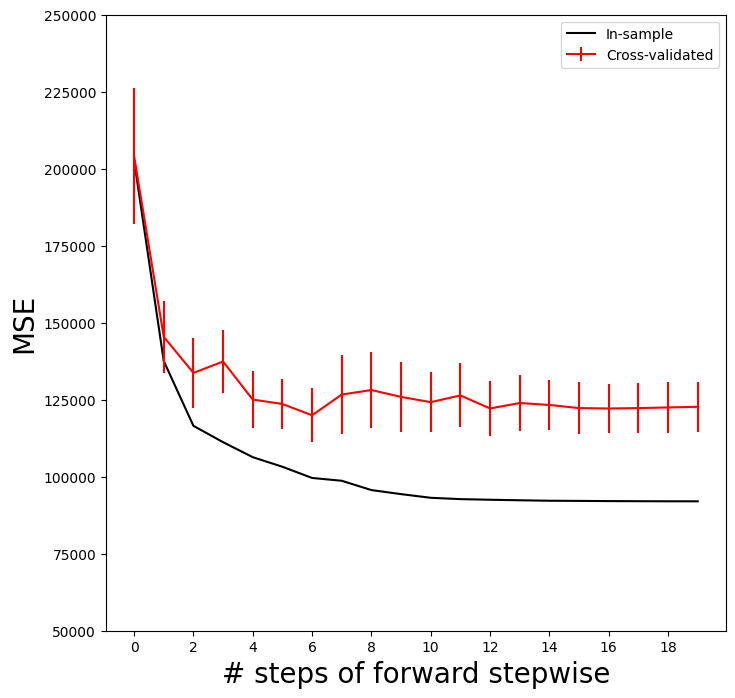

In [15]:
ax.errorbar(np.arange(n_steps), 
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

Validation set approach with a validation set of 20% the original size (same as the 5fold CV).

In [16]:
validation = skm.ShuffleSplit(n_splits=1, 
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)

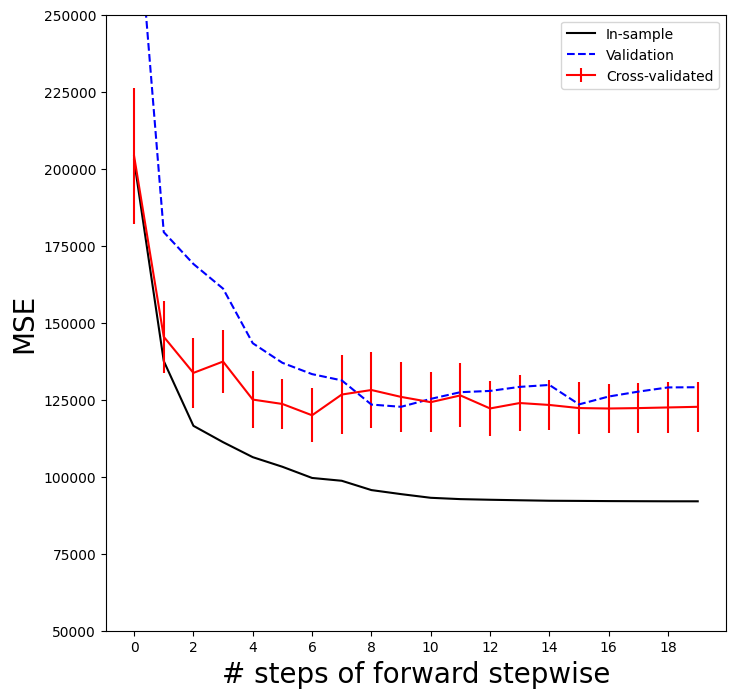

In [17]:
ax.plot(np.arange(n_steps), 
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig


### Best Subset Selection

Instead of constraining the subset to be a given size, this package produces a path of solutions using the subset size as a penalty rather than a constraint. Although the distinction is subtle, the difference comes when we cross-validate. 

In [18]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

path = fit_path(X, # model matrix without intercept
                Y,
                max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


Returns several items, e.g. B (list of the fitted coefficients) and B0 (intercept).

By number of non-zero items, we can infer the penalty parameter lambda_0. E.g. for 2 non-zero coefficients, lambda_0 would be 0.0114.

In [19]:
path[3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450187,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

## Ridge Regression and Lasso

- `skl.ElasticNet()`: fits ridge regression and lasso
- `skl.ElasticNet.path()`: fits both over a path of models
- Ridge Regression corresponds to l1_ratio = 0
- variables need to be standardized before!
- sklearn calls lambda (the tuning parameter) `alphas`

In [20]:
Xs = X - X.mean(0)[None,:] # unstandardize (X is multidimensional, so the X.mean has to be made multidimensional too)
X_scale = X.std(0) # getting standard deviation
Xs = Xs / X_scale[None,:] # standardize again
lambdas = 10**np.linspace(8,-2,100) / Y.std()
soln_array = skl.ElasticNet.path(Xs, # model matrix, standardized
                                 Y, # response
                                 l1_ratio=0., # define model (here: ridge regression)
                                 alphas=lambdas)[1] # tuning parameters
print(soln_array.shape) # array of ridge coefficients; 19 rows / predictors and 100 columns / values of lambda each

(19, 100)


c:\Users\lbrau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\lbrau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428165.36474803, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\lbrau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\lbrau\AppData\Lo

In [21]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)' # negative log, so the inverse to the graphic where all coefficients converge to 0
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


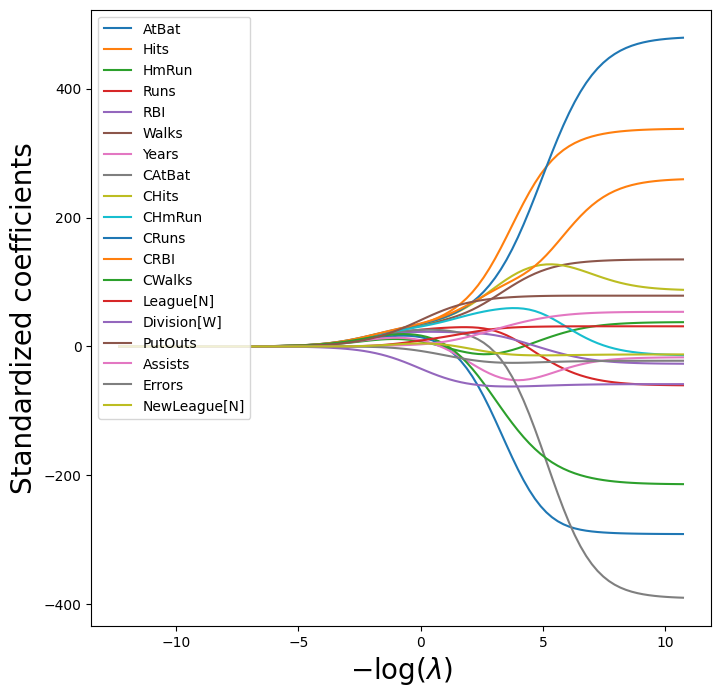

In [22]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left')

In [23]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

In [24]:
print(np.linalg.norm(beta_hat))

beta_hat = soln_path.loc[soln_path.index[59]]
print(lambdas[59], np.linalg.norm(beta_hat))

24.17061720144378
0.24374766133488554 160.42371017726032
